# **User Identification From Walking Activity**

**Abstract**<br><br>
The dataset collects data from an Android smartphone positioned in the chest pocket. Accelerometer Data are collected from 22 participants walking in the wild over a predefined path. The dataset is intended for Activity Recognition research purposes. It provides challenges for identification and authentication of people using motion patterns.

**Relevant Information**
   - The dataset collects data from an Android smartphone accelerometer positioned in the chest pocket
   - Sampling frequency of the accelerometer: DELAY_FASTEST with network connections disabled
   - Number of Participants: 22
   - Data Format: CSV

**Dataset Information**
   - Data are separated by participant
   - Each file contains the following information
   - time-step, x acceleration, y acceleration, z acceleration

## Feature selection
Since the dataset is labeled by participant's ID number, the natural technique to employ for solving this problem is "clustering". The dataset for each participant is time series of 3 quantities; acceleration in x, y, and z direction (hereafter denoted as ax, ay, and az) measured by accerometer in an Android cellphone carried in the chest pocket. See the example data for participant 2, 6, and 8 below (22 participants in total).

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


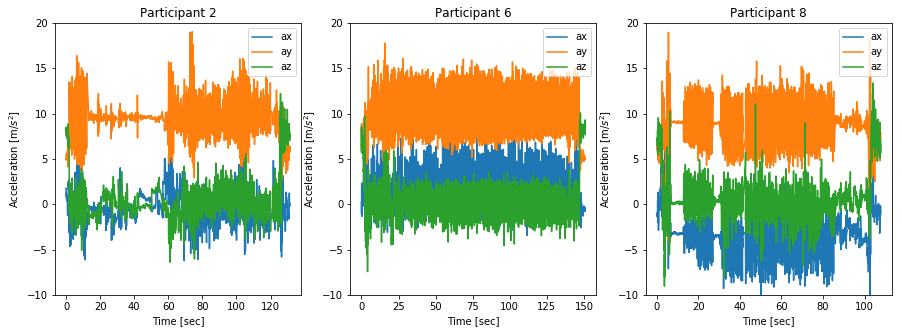

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read-in entire dataset
data = []
for i in range( 1, 23 ):
    data.append( pd.read_csv( 'data/%02d.csv'%i, names = [ 't', 'ax', 'ay', 'az' ]) )

# plotting class for repetitive usage
class plotting(object):
    def __init__( self, data ): self.data = data
    def plot_data( self, ID, f, alpha, title, legend=True ):
        f.plot( self.data[ID-1]['t'], self.data[ID-1]['ax'], alpha=alpha, label="ax") # -1 for 0 index
        f.plot( self.data[ID-1]['t'], self.data[ID-1]['ay'], alpha=alpha, label="ay")
        f.plot( self.data[ID-1]['t'], self.data[ID-1]['az'], alpha=alpha, label="az")
        f.set_ylim(-10,20)
        f.set_title( title )
        f.set_xlabel( 'Time [sec]' ); f.set_ylabel( r'Acceleration [m/$s^2$]' )
        if legend: f.legend( loc='upper right', fancybox=True )

# example plots for time vs. acceleration for 3 participants
p = plotting(data)
fig = plt.figure(figsize=(15,5))
f = fig.add_subplot(131); p.plot_data( 2, f, 1., 'Participant 2' )
f = fig.add_subplot(132); p.plot_data( 6, f, 1., 'Participant 6' )
f = fig.add_subplot(133); p.plot_data( 8, f, 1., 'Participant 8' )
plt.show()

The time stamp is 0.03 seconds on average (but non-uniformly sampled), and therefore the example participants 2, 6, and 8 above have ~3900, ~4900, and ~3500 data points for each variable, respectively. Each data point, however, does not have much information and cannot be used as a training data point: time series data have meaning only when they are analyzed as series. The strategy we should take is, then, dividing each series into smaller segments and use each segment as one data point to extract the features.

The simplest features are an average value and standard deviation of each variable for a given time segment. Figure below shows a series of average value with standard deviation indicated by the error bars, for the above 3 participants with a segmentation size $\Delta T=10$ (sec).

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


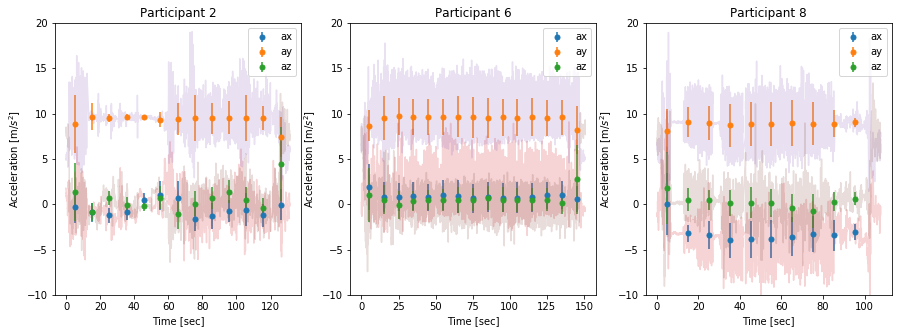

In [26]:
# parsing data into DT
class parse_data(object):
    def __init__( self, data, DT ):
        self.DT = DT
        self.data_parsed = []
        for d in data: self.data_parsed.append(self.parsing( d ))
        self.t_parsed_avg = []
        self.data_parsed_avg = []
        self.sig_parsed_avg = []
        for d in self.data_parsed:
            t_avg, d_avg, sig_avg = self.averaging( d )
            self.t_parsed_avg.append( t_avg )
            self.data_parsed_avg.append( d_avg )
            self.sig_parsed_avg.append( sig_avg )

    def parsing( self, data ):
        t_s = data['t'][0]
        t_e = t_s + self.DT
        i_s = 0
        data_parsed = []
        # need to loop since it's unevely sampled...
        for i, t in enumerate(data['t']):
            if t > t_e:
                data_parsed.append(data.iloc[i_s:i,:])
                i_s = i
                t_e = t + self.DT
        return data_parsed

    def averaging( self, data_parsed ):
        # calculate average and standard dev. for each segment
        t_avg = []; d_avg = []; sig = []
        for d in data_parsed:
            t_avg.append( np.average(d['t']) )
            cols = d.iloc[:,1:]
            d_avg.append( [np.average(cols[col]) for col in cols] )
            sig.append(   [np.std(    cols[col]) for col in cols] )
        d_avg = list(map( list, zip(*d_avg) ))
        sig   = list(map( list, zip(*sig  ) ))
        return t_avg,d_avg,sig

def plot_parse( par, ID, f ):
    t = par.t_parsed_avg[ID-1]; data = par.data_parsed_avg[ID-1]; sig = par.sig_parsed_avg[ID-1]
    f.errorbar( t, data[0], yerr=sig[0], fmt='.', ms=10, label='ax' )
    f.errorbar( t, data[1], yerr=sig[1], fmt='.', ms=10, label='ay' )
    f.errorbar( t, data[2], yerr=sig[2], fmt='.', ms=10, label='az' )
    plt.legend( loc='upper right' )
    

DT = 10. # segment size in second
par = parse_data( data, DT )

fig = plt.figure(figsize=(15,5))
f1 = fig.add_subplot(131); plot_parse( par, 2, f1 )
f2 = fig.add_subplot(132); plot_parse( par, 6, f2 )
f3 = fig.add_subplot(133); plot_parse( par, 8, f3 )

p = plotting( data )
p.plot_data( 2, f1, 0.2, 'Participant 2', legend=False )
p.plot_data( 6, f2, 0.2, 'Participant 6', legend=False )
p.plot_data( 8, f3, 0.2, 'Participant 8', legend=False )
plt.show()